# Computing Project - Initial

#### Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#### Constants

In [14]:
G = 6.67430e-11 # m^3 kg^-1 s^-2
m_e = 5.972e24 # kg
m_m = 7.348e22 # kg
d = 384400000 # m
time_step = 10 #s

In [15]:
T = 2*np.pi*np.sqrt(d**3/(G*(m_e + m_m)))
max_time = 2*T
time = np.arange(0, max_time, time_step) #s
n_steps = len(time)

### Initial Conditions

In [54]:
initial_earth, initial_moon = pos_earth_moon(0)
pos_L2 = [initial_moon[0]+d*(m_m/(3*m_e))**(1/3), 0] # m
v_L2 = [0,-(2*np.pi/T) * pos_L2[0]]

(-500000000.0, 500000000.0)

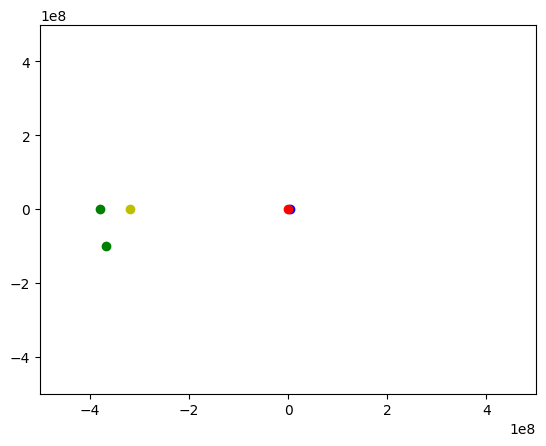

In [55]:
plt.plot(initial_earth[0], initial_earth[1], 'bo', label='Earth')
plt.plot(initial_moon[0], initial_moon[1], 'go', label='Moon')
plt.plot(pos_moon[:,10000][0], pos_moon[:,10000][1], 'go', label='Moon')
plt.plot(pos_L2[0], pos_L2[1], 'yo', label='L2')
plt.plot(0,0, 'ro', label='Barycenter')
plt.xlim(-5e8, 5e8)
plt.ylim(-5e8, 5e8)

In [56]:
#r0 = np.array([ 4.672203365e6, 6.571000e6])  # m
#v0 = np.array([ 10988.378, 12.452740 ]) # m/s

r0 = pos_L2
v0 = v_L2

## Functions

In [ ]:
def pos_earth_moon(t,circular=True):
    """
    This function returns the position of the Earth-Moon about it's barycenter at time t

    Inputs: 
        time_step - interval of time in seconds which the position is to be calculated

    Outputs
        pos_earth - Array size (2,int(max_time/timestep))
        pos_moon - Array size (2,int(max_time/timestep))
    """
    if circular:
        # Angular velocity
        omega = 2*np.pi/T # rad/s

        # Earth 
        r_e = d*m_m/(m_e + m_m) # m
        x_e = r_e * np.cos(omega*t) #x, m
        y_e = r_e * np.sin(omega*t) #y, m

        # Moon 
        r_m = d*m_e/(m_e + m_m) # m
        x_m = r_m * np.cos(omega*t + np.pi) #x, m
        y_m = r_m * np.sin(omega*t + np.pi) #y, m

        pos_earth = np.array([x_e, y_e])
        pos_moon = np.array([x_m, y_m])
        return pos_earth, pos_moon
    else:
        raise(NotImplementedError("Elliptical orbits not yet implemented"))

### Solving ODE

In [ ]:
def acceleration(r, t):
    '''
    This function calculates the acceleration on a rocket at position (x,y) at time t
    '''
    pos_earth, pos_moon = pos_earth_moon(t)
    x = r[0]
    y = r[1]
    
    # Distance vectors
    r_earth = np.array([x - pos_earth[0], y - pos_earth[1]])
    r_moon = np.array([x - pos_moon[0], y - pos_moon[1]])

    # Magnitudes
    r_earth_mag = np.linalg.norm(r_earth)
    r_moon_mag = np.linalg.norm(r_moon)

    # Calculate acclerations
    a_earth = -G * m_e * r_earth / r_earth_mag**3
    a_moon = -G * m_m * r_moon / r_moon_mag**3

    return a_earth + a_moon

In [ ]:
def evolve(r_rocket,v_rocket, n_steps, method = 'RK4'):
    
    # Preallocate
    r = np.zeros((2, n_steps))
    v = np.zeros((2, n_steps))
    r[:, 0] = r0
    v[:, 0] = v0
    
    if method == 'Taylor':
        for i in range(n_steps-1):
            a_rocket = acceleration(r[:, i], time[i])
            
            r[:, i+1] = r[:, i] + time_step * v[:, i] + 0.5 * time_step**2 * a_rocket
            v[:, i+1] = v[:, i] + time_step * a_rocket

    elif method == 'RK4':
        for n in range(n_steps-1):
            # z1
            z1 = r[:,n] + 0.5*time_step*v[:,n]

            r_ddot = acceleration(r[:, n], time[n])
            z1_dot = v[:,n] + 0.5*time_step*r_ddot

            #z2
            z2 = r[:,n] + 0.5*time_step*z1_dot

            z1_ddot = acceleration(z1, time[n]+0.5*time_step)
            z2_dot = v[:,n] + 0.5*time_step*z1_ddot

            #z3
            z3 = r[:,n] + time_step*z2_dot

            z2_ddot = acceleration(z2, time[n]+0.5*time_step)
            z3_dot = v[:,n] + time_step*z2_ddot

            z3_ddot = acceleration(z3, time[n]+time_step)

            # Combine
            r[:, n+1] = r[:, n] + (1/6)*time_step*(v[:, n] + 2*z1_dot + 2*z2_dot + z3_dot)
            v[:, n+1] = v[:, n] + (1/6)*time_step*(r_ddot + 2*z1_ddot + 2*z2_ddot + z3_ddot)


    return r, v

In [57]:
pos_rocket, v_rocket = evolve(r0,v0, n_steps,method = 'RK4')
pos_earth, pos_moon = pos_earth_moon(time)

## Plotting

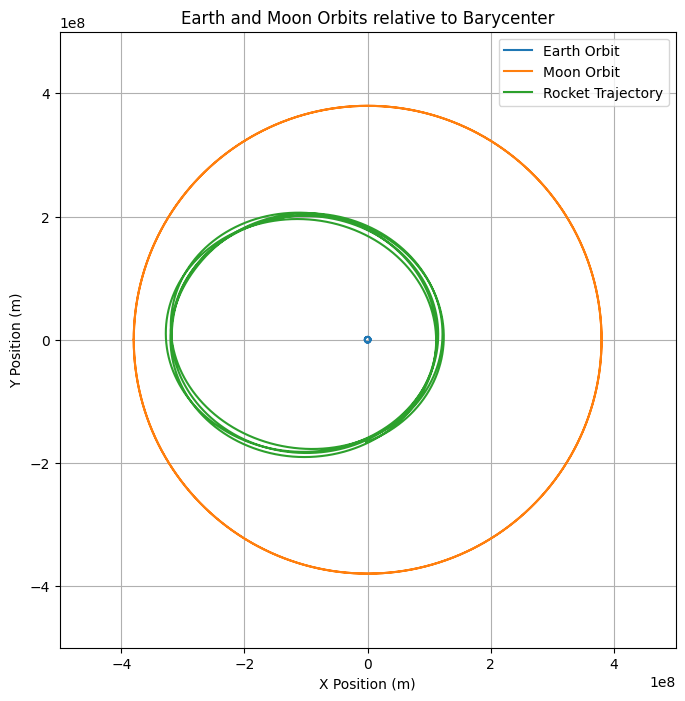

In [ ]:
fig = plt.figure(figsize=(8, 8))  
ax = plt.axes()  

ax.plot(pos_earth[0], pos_earth[1], label='Earth Orbit')
ax.plot(pos_moon[0], pos_moon[1], label='Moon Orbit')
ax.plot(pos_rocket[0], pos_rocket[1], label='Rocket Trajectory')


ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_title('Earth and Moon Orbits relative to Barycenter')
ax.legend()
ax.grid(True)
ax.set_xlim(-5e8, 5e8)
ax.set_ylim(-5e8, 5e8)
ax.set_aspect('equal', 'box')

plt.show()